In [1]:
# libraries for data exploration.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# library for splitting data.
from sklearn.model_selection import train_test_split

# libraries for preparing the data.
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

# libraries for building linear models.
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# library for measuring error. 
from sklearn.metrics import mean_squared_error

# time series specific libararies
from scipy.signal import periodogram
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# user defined.
from helpful_functions import MLFunctions

In [2]:
# load sales data.
sales = pd.read_csv("../../../Data/future_sales/sales_train.csv",
                    parse_dates=['date'])

In [3]:
# setting up matplotlib. 
plt.rc("figure", autolayout=True, figsize=(11, 11))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

In [5]:
sales['date'] = pd.to_datetime(sales['date'], format="%d.%m.%Y")
sales = sales.sort_values(by='date')

In [8]:
sales = sales.groupby(['date', 'shop_id']).mean()

In [23]:
dictionary = dict()
count = 0
arr = []
for time in sales.index:
    if time[0] not in dictionary:
        dictionary[time[0]] = count
        count += 1
    else:
        pass

for time in sales.index:
    arr.append(dictionary[time[0]])

In [11]:
sales['dummy_time'] = arr

In [4]:
average_items_sold = sales.groupby('date')

In [5]:
df = average_items_sold.to_frame()

In [6]:
df.index = pd.to_datetime(df.index, format="%d.%m.%Y")

In [8]:
df = df.sort_index()

In [9]:
time = np.arange(len(df.index))
df['time'] = time

In [58]:
X = sales.loc[:, ['dummy_time']]
y = sales.loc[:, 'item_cnt_day']

In [60]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [62]:
y_pred = pd.Series(model.predict(X), index=X.index)

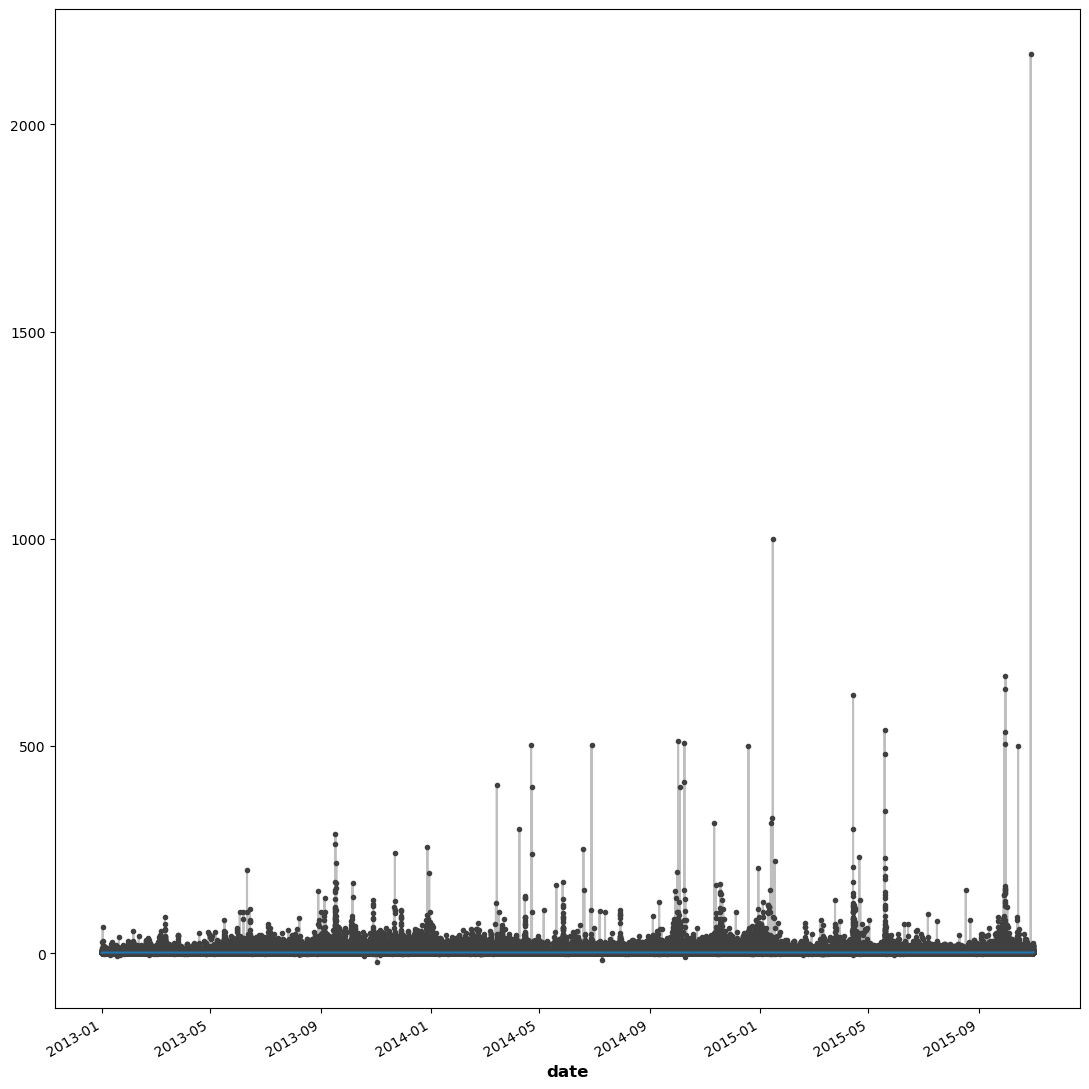

In [64]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax)

In [24]:
df2 = average_items_sold.to_frame()

In [25]:
df2.index = pd.to_datetime(df2.index, format="%d.%m.%Y")

In [26]:
df2 = df2.sort_index()

In [31]:
lag_1 = df2['item_cnt_day'].shift(1)
df2['lag_1'] = lag_1
X = df2.loc[:, ['lag_1']].dropna()
y = df2.loc[:, 'item_cnt_day']

In [33]:
y, X = y.align(X, join='inner')

In [35]:
model2 = LinearRegression()
model2.fit(X,y)

LinearRegression()

In [37]:
y_pred = pd.Series(model2.predict(X), index=X.index)

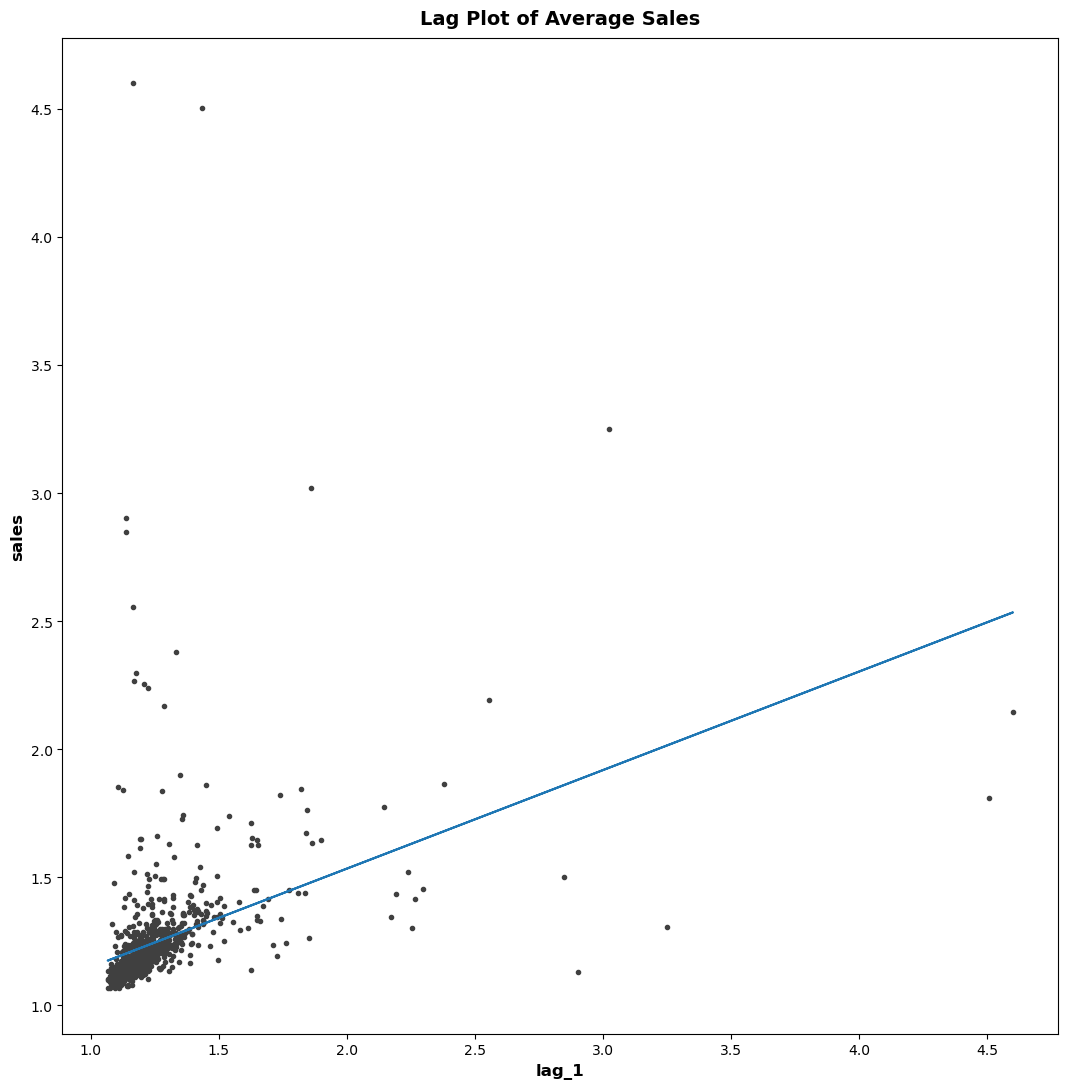

In [39]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

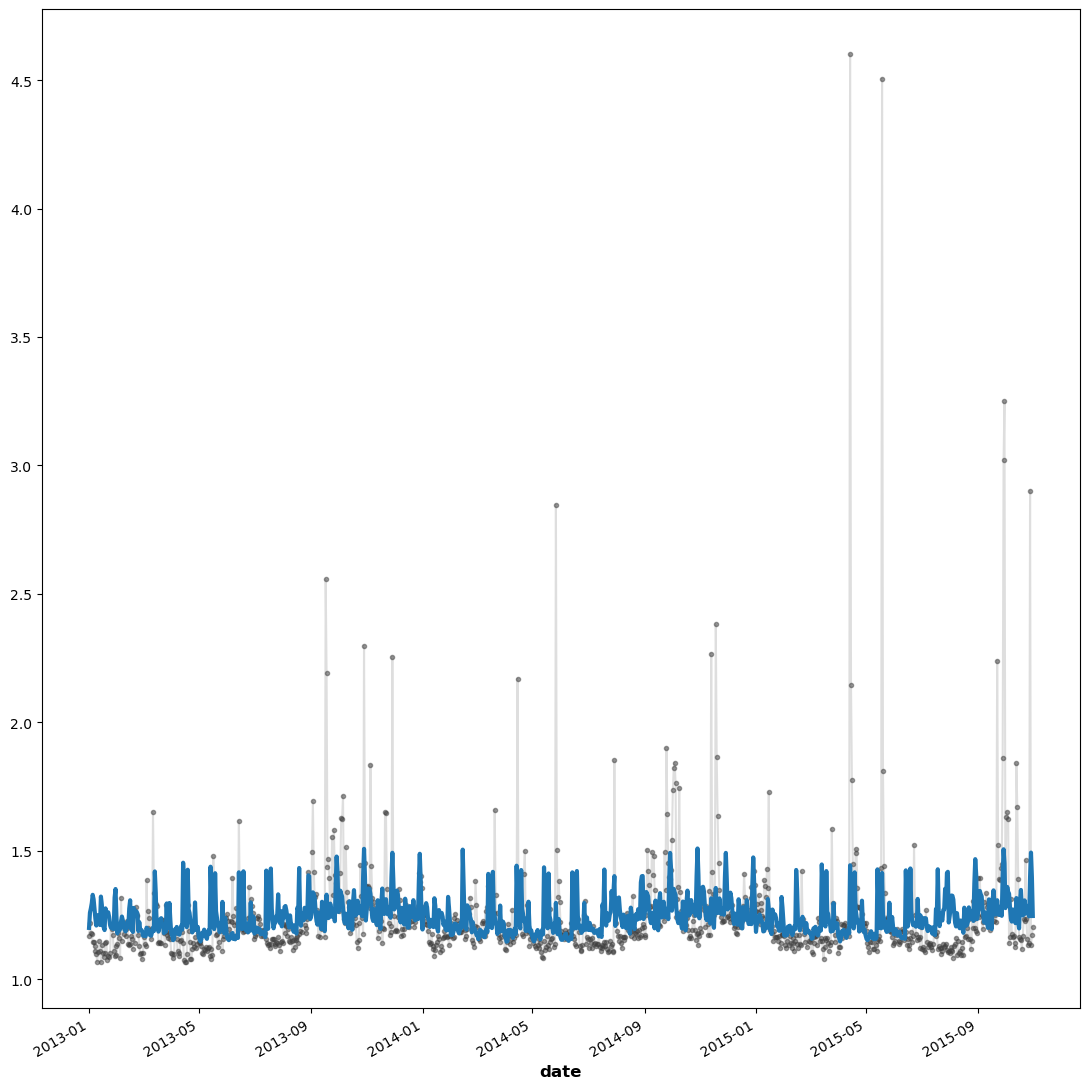

In [101]:
trend = average_items_sold.rolling(
    window=15,
    center=True,
    min_periods=7
    ).mean()

# Make a plot
ax = average_items_sold.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

In [85]:
experiment_df = average_items_sold
experiment_df.index = pd.to_datetime(experiment_df.index, format="%d.%m.%Y")
experiment_df = experiment_df.sort_index()
experiment_df = experiment_df.asfreq('D')

In [87]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = experiment_df.copy()  # the target

# YOUR CODE HERE: Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(
    index=y.index,
    order=3
)

# YOUR CODE HERE: Create the feature set for the dates given in y.index
X = dp.in_sample()

# YOUR CODE HERE: Create features for a 30-day forecast.
X_fore = dp.out_of_sample(steps=30)


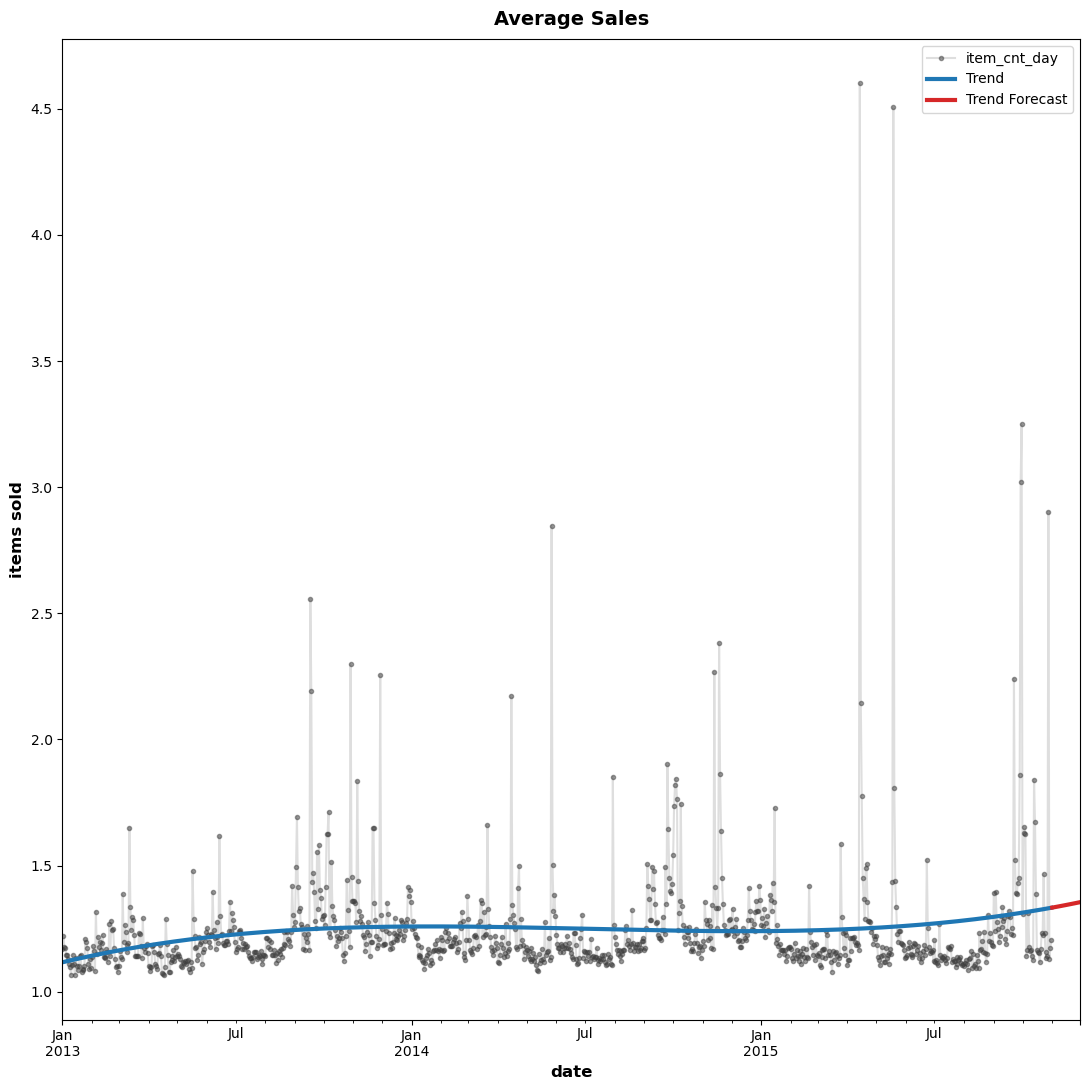

In [91]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

In [ ]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [ ]:
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax